<a href="https://colab.research.google.com/github/viniciusrpb/greenalgaclassification/blob/master/selenastraceae_keras_cnnmodels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#!ls "/content/drive/My Drive"

!cp -r "/content/drive/My Drive/alga/roi_train" "roi_train"
!cp -r "/content/drive/My Drive/alga/roi_test" "roi_test"

In [5]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model

In [10]:
path_train = 'roi_train'
path_test = 'roi_test'

# Pretrained GoogLeNet model using ImageNet


In [6]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

for layer in pre_trained_model.layers:
  layer.trainable = False

87916544/87910968 [==============================] - 1s 0us/step


Define a Callback class that stops training once accuracy reaches 95%

In [7]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.959):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

### Data augmentation

In [18]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(path_train,
                                                    batch_size = 20,
                                                    class_mode = 'categorical', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( path_test,
                                                          batch_size  = 20,
                                                          class_mode  = 'categorical', 
                                                          target_size = (150, 150))

Found 280 images belonging to 8 classes.
Found 123 images belonging to 8 classes.


In [16]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(pre_trained_model.output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.01), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [19]:
callbacks = myCallback()
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 10,
            epochs = 10,
            validation_steps = 50,
            verbose = 2,
            callbacks=[callbacks])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
10/10 - 8s - loss: 188.0818 - acc: 0.6988 - val_loss: 16.1951 - val_acc: 0.8750
Epoch 2/10
10/10 - 2s - loss: 14.5585 - acc: 0.7588
Epoch 3/10
10/10 - 2s - loss: 7.7105 - acc: 0.7625
Epoch 4/10
10/10 - 2s - loss: 1.3910 - acc: 0.8413
Epoch 5/10
10/10 - 2s - loss: 0.5022 - acc: 0.8637
Epoch 6/10
10/10 - 2s - loss: 0.4865 - acc: 0.8675
Epoch 7/10
10/10 - 2s - loss: 0.4553 - acc: 0.8750
Epoch 8/10
10/10 - 2s - loss: 0.6087 - acc: 0.8637
Epoch 9/10
10/10 - 2s - loss: 0.7085 - acc: 0.8712
Epoch 10/10
10/10 - 2s - loss: 0.6328 - acc: 0.8712


In [ ]:
alga_train = alga_train.new(
    item_tfms=Resize(512, ResizeMethod.Pad, pad_mode='reflection'),
    #batch_tfms=aug_transforms(do_flip=True,flip_vert=True))
    batch_tfms=aug_transforms(mult=4, pad_mode='reflection', do_flip=True, 
                                flip_vert=True,max_rotate=180.0,min_scale=0.5,max_zoom=1.5))#, max_rotate=5.0, align_corners=True, 
                                #max_zoom=0.5, p_affine=0.75, p_lighting=0))
    #batch_tfms=aug_transforms(RandomRotate(10), RandomLighting(0.05, 0.05)))

dls_train_val = alga_train.dataloaders(training_set,bs=64)

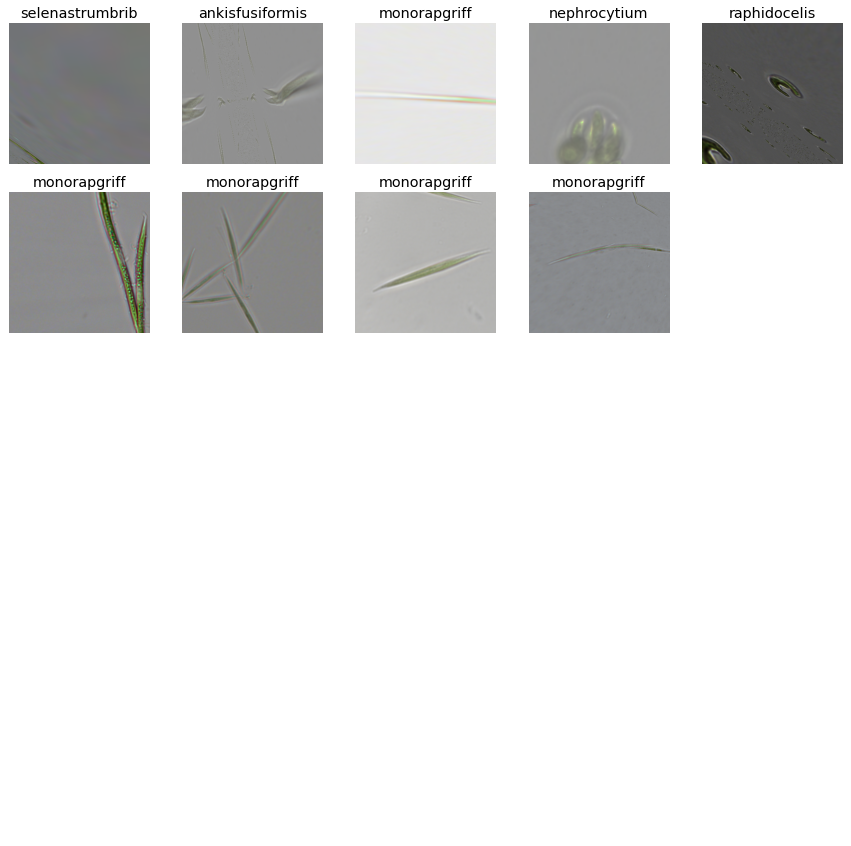

In [ ]:
dls_train_val.show_batch(nrows=5, ncols=5)

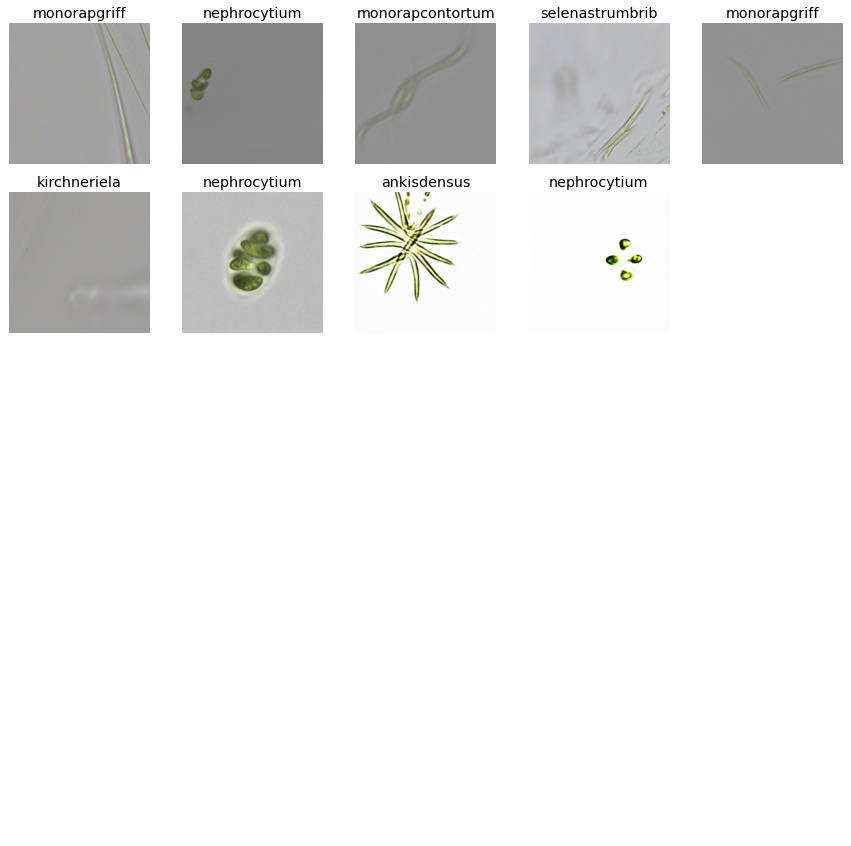

In [ ]:
dls_train_val.show_batch(nrows=5, ncols=5)

### Set F1-Score as the official performance measure

In [ ]:
# load model without output layer
model = VGG16(include_top=False)

Minimum/10: 1.00e-02, steepest point: 1.10e-02


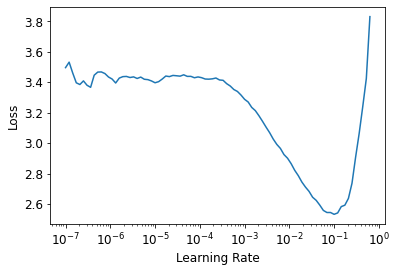

In [ ]:
resnet_learner = cnn_learner(dls_train_val, resnet34, pretrained=True, loss_func = CrossEntropyLossFlat(), metrics=[error_rate,f1])
lr_min,lr_steep = resnet_learner.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

epoch,train_loss,valid_loss,error_rate,fbeta_score,time
0,3.338228,2.501064,0.775000,0.193999,00:09


epoch,train_loss,valid_loss,error_rate,fbeta_score,time
0,2.439637,1.852211,0.650000,0.264408,00:13
1,2.462042,1.746509,0.637500,0.305289,00:12
2,2.433232,1.646700,0.537500,0.447411,00:13
3,2.318887,1.509989,0.512500,0.446596,00:11
4,2.257957,1.332425,0.425000,0.546988,00:11
5,2.141061,1.188347,0.312500,0.666401,00:12
6,2.037750,1.110710,0.300000,0.682017,00:12
7,1.910071,0.959075,0.250000,0.736788,00:13
8,1.809919,0.608638,0.200000,0.780094,00:13
9,1.728740,0.487539,0.162500,0.803223,00:11


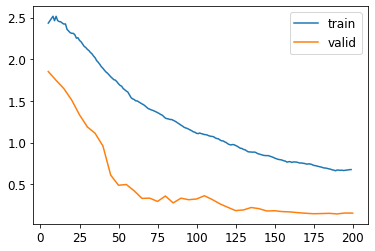

In [ ]:
#alexnet_learner.fit_one_cycle(12,0.01)
#alexnet_learner.unfreeze()
#alexnet_learner.fit_one_cycle(12,lr_max=slice(1e-6,1e-4))

#Trains the randomly added layers for one epoch, with all other layers frozen
#Unfreezes all of the layers, and trains them all for the number of epochs requested
resnet_learner.fine_tune(40,lr_base=1e-2)
resnet_learner.recorder.plot_loss()

AssertionError: ignored

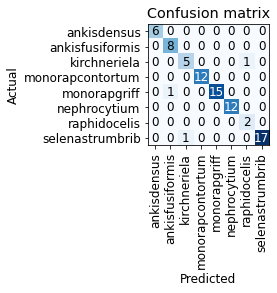

In [ ]:
interp = ClassificationInterpretation.from_learner(alexnet_learner)
interp.plot_confusion_matrix()

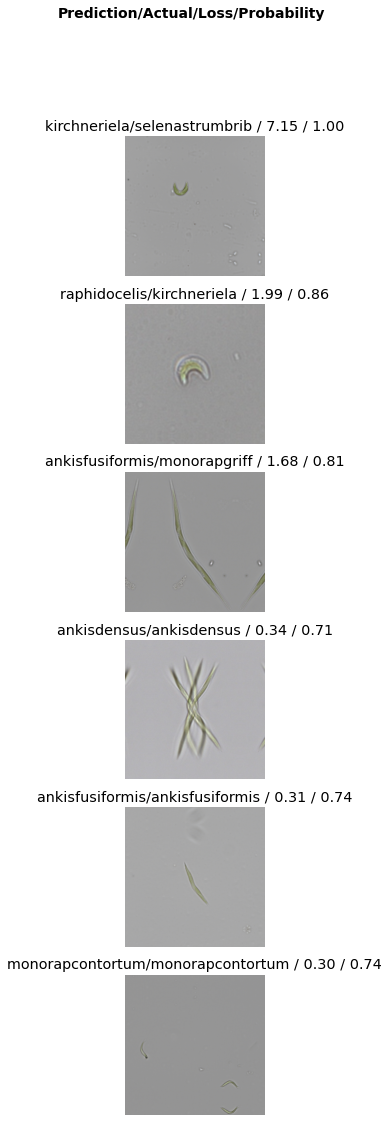

In [ ]:
# In the first output shows that the highest loss is an image that has been predicted as
# "monoraphidium" with high confidence, but it was labeled as "selenastraceae"

interp.plot_top_losses(6, nrows=6)

### Evaluation performance using the Test Set

In [ ]:
test_set = Path(path_test)

test_files = get_image_files(test_set)

test_dl = alexnet_learner.dls.test_dl(test_files, with_label=True)

In [ ]:
pred_probas, _,pred_classes = alexnet_learner.get_preds(dl=test_dl, with_decoded=True)

print(alexnet_learner.dls.vocab)

print(pred_classes)


(#8) ['ankisdensus','ankisfusiformis','kirchneriela','monorapcontortum','monorapgriff','nephrocytium','raphidocelis','selenastrumbrib']
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 2, 7, 7,

In [ ]:
def plotConfusionMatrix(classifier,X_test,y_test,y_pred,class_names):
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    titles_options = [("Confusion matrix, without normalization", None),("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(classifier, X_test, y_test,display_labels=class_names,cmap=plt.cm.Blues)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    plt.show()
    return ;



In [ ]:
print(confusion_matrix(y_test, y_pred))
plotConfusionMatrix(gnb,X_test,y_test,y_pred,labels)